<img src="pics/otus.png">

In [68]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from pandas.tools.plotting import table
from sklearn import datasets

%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 8]

np.random.seed(42)


# Логистическая регрессия

## Как принимается решение

Простой вариант - узнать, с какой стороны от гиперплоскости находится точка

$$\hat{y} = sign(x\theta)$$

Уравнение прямой
      $$Ax+By+C=0$$

Расстояние от точки $(x0, y0)$ до прямой $Ax+By+C=0$ это $$\frac{|Ax0 + By0 + C|}{\sqrt{(A^2 + B^2)}}$$

## Упражнение 1

In [189]:
w = np.array([7, -1, 1]) # Ax + By + C = 0

# Замечание: расстояние от точки (x0, y0) до прямой Ax + By + C это abs(Ax0 + By0 + C) / sqrt(A^2 + B^2)

def predict(points, w):
    result = []
    [a_coef, b_coef, c_coef] = w

    for [x0, y0, _useles_param] in points:
        sign = a_coef * x0 + b_coef * y0 + c_coef
        result += [sign]

    return np.array(result)

x_pred = np.hstack([np.random.rand(10, 2) * 4 - 2, np.ones(10).reshape(-1, 1)])
y_pred = predict(x_pred, w)

print(x_pred.shape)
print(y_pred.shape)


(10, 3)
(10,)


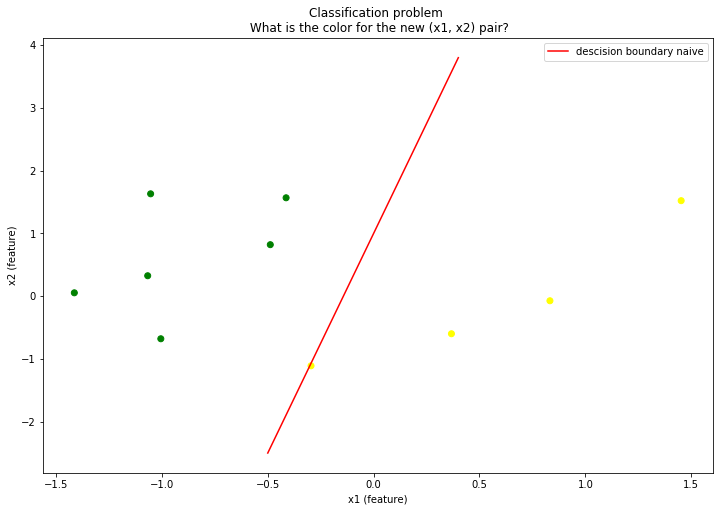

In [190]:
x_naive = np.arange(-0.5, 0.5, 0.1)
y_naive = 7 * x_naive + 1

plt.scatter(x_pred[:, 0], x_pred[:, 1], c=['yellow' if y_i > 0 else 'green' for y_i in y_pred])
plt.title("Classification problem \n What is the color for the new (x1, x2) pair?")
plt.xlabel("x1 (feature)")
plt.ylabel("x2 (feature)")
plt.plot(x_naive, y_naive, c='red', label='descision boundary naive')
plt.legend()
# plt.savefig('pics/classification_random_line.pdf')

# Градиентный спуск



Посчитаем, чему равен градиент функции потерь $RSS(\theta)$

$$ RSS = \mathcal{L}(\theta) = (\hat{y} - y)^2 $$

$$ \frac{\partial L}{\partial \theta_i} = 2(\hat{y} - y)\frac{\partial L}{\partial \theta_i}(\hat{y} - y) = 2(\hat{y} - y)\frac{\partial L}{\partial \theta_i}(\theta_0x_0 + ... + \theta_1x_1 - y) = 2(\hat{y} - y)\cdot x_i$$

$$ \theta_i:= \theta_i - \alpha(\hat{y} - y)\cdot x_i$$

Или:
$$ \frac{\partial RSS(\theta)}{\partial \theta_i} = 2\sum_{i=1}^{n}(\theta^T\cdot x_i - y_i)x_i$$

$$\nabla_\theta RSS(\theta) = \left( \begin{matrix} \frac{\partial L}{\partial \theta_0} \\ \frac{\partial L}{\partial \theta_1} \\ ... \\ \frac{\partial L}{\partial \theta_p} \end{matrix} \right) = x^\top(x\theta - y)$$


Для MSE:
$$ \frac{\partial L}{\partial \theta} = \frac{1}{n} X^\top(X\theta - y)$$

In [191]:
np.random.seed(42)
x = 2 * np.random.rand(100, 1)
y = 4 + 3 * x + np.random.randn(100, 1)

In [192]:
lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.21509616]), array([[2.77011339]]))

In [193]:
theta_best = np.vstack([lin_reg.intercept_, lin_reg.coef_.ravel()])

In [194]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.21509616],
       [9.75532293]])

## Псевдокод алгоритма

```{python}
1.function gd(X, alpha, epsilon):
2.    initialise theta 
3.    do: 
4.        theta = new_theta
5.        new_theta = theta - alpha * grad(X, theta)
6.    until dist(new_theta, theta) < epsilon
7.    return theta
```

## Упражнение 2

In [204]:
X_b = np.c_[np.ones((100, 1)), X]

def print_theta(th):
    [[first_coefficient], [second_coefficient]] = th
    return "({0}, {1})".format(first_coefficient, second_coefficient)

def calculate_theta_by_gradient(X, Y, theta, alpha, eps, n_iterations = 1000):
    initial_theta = theta
    m = len(X)
    iterations_count = 0
    dist = 0
    for iteration in range(n_iterations):
        gradients = 1. / m * X.T.dot(X.dot(theta) - Y)
        theta = theta - alpha * gradients
        dist = np.linalg.norm(-1 * alpha * gradients)
        iterations_count = iteration + 1
        if dist < eps:
            break


    print('Gradient descent')
    print('Iterations: {0}.\nDist: {1}.\nInitial theta: {2}.\nGradient generated theta: {3}'.format(iterations_count, dist, print_theta(initial_theta), print_theta(theta)))
    return theta

X_b = np.c_[np.ones((100, 1)), X]
random_theta = np.random.randn(2,1)
alpha = 0.1
eps = 0.0001

calculate_theta_by_gradient(X_b, y, random_theta, alpha, eps, 2000)
print('Best theta: {0}'.format(print_theta(theta_best)))


Gradient descent
Iterations: 345.
Dist: 9.892799447772617e-05.
Initial theta: (-0.9764265916915398, 0.06753977906994638).
Gradient generated theta: (4.210800667110931, 2.7739060710126378)
Best theta: (4.215096157546747, 2.7701133864384833)


## Стохастический градиентный спуск


Проблема - используется вся обучающая выборка на каждом шаге алгоритма  
Решение - использовать один случайный элемент выборки

### Градиентный спуск

```{python}
1.function gd(X, alpha, epsilon):
2.    initialise theta 
3.    do: 
4.        theta = new_theta
5.        new_theta = theta - alpha * grad(X, theta)
6.    until dist(new_theta, theta) < epsilon
7.    return theta
```

### Стохастический градиентный спуск

```{python}
1.function sgd(X, alpha, epsilon):
2. 	initialise theta 
3. 	do: 
4.        X = shuffle(X)
5.        for x in X:
6.            theta = new_theta
7.            new_theta = theta - alpha * grad(x, theta)
8.	until dist(new_theta, theta) < epsilon
9.	return theta
```

In [205]:
m = len(X_b)
alpha = 0.01
n_epochs = 100

theta = np.random.randn(2,1)

X_b = np.c_[np.ones((100, 1)), X]

def print_theta(th):
    [[first_coefficient], [second_coefficient]] = th
    return "({0}, {1})".format(first_coefficient, second_coefficient)

def stochastic_calculate_theta_by_gradient(X, Y, theta, alpha, eps, n_epochs = 100):
    initial_theta = theta
    m = len(X)
    epoch_count = 0
    iterations = 0
    dist = 0
    for _epoch in range(n_epochs):
        shuffled_array = np.hstack((X_b, y))
        np.random.shuffle(shuffled_array)
        dist = eps + 1
        for [x0, x1, y_val] in shuffled_array:
            x_vector = np.array([[x0, x1]])
            y_value = np.array([[y_val]])
            gradient = x_vector.T.dot(x_vector.dot(theta) - y_value)
            theta = theta_old - alpha * gradient
            dist = np.linalg.norm(-1 * alpha * gradient)
            iterations += 1
            if dist < eps:
                break
        epoch_count += 1

        if dist < eps:
            break

    print('Stochastic gradient descent')
    print('Iterations: {0}.\nEpochs: {1}.\nDist: {2}.\nInitial theta: {3}.\nGradient generated theta: {4}'.format(iterations, epoch_count, dist, print_theta(initial_theta), print_theta(theta)))
    return theta

X_b = np.c_[np.ones((100, 1)), X]
random_theta = np.random.randn(2,1)
n_epochs = 100
alpha = 0.1
eps = 0.0001

stochastic_calculate_theta_by_gradient(X, y, random_theta, alpha, eps, n_epochs)
print('Best theta: {0}'.format(print_theta(theta_best)))

Stochastic gradient descent
Iterations: 921.
Epochs: 10.
Dist: 5.77076698002735e-05.
Initial theta: (1.6240197994726442, -0.020155336347329265).
Gradient generated theta: (4.210686198951724, 2.7739321060965043)
Best theta: (4.215096157546747, 2.7701133864384833)


In [216]:
def compare_descendts(number_elements, alpha, eps, iterations, n_epochs):
    np.random.seed(42)
    rand_x = 2 * np.random.rand(number_elements, 1)
    rand_y = 4 + 3 * rand_x + np.random.randn(number_elements, 1)
    rand_theta = np.random.randn(2,1)
    x_collection = np.c_[np.ones((number_elements, 1)), rand_x]
    
    lin_reg = LinearRegression()
    lin_reg.fit(X, y)
    lin_reg.intercept_, lin_reg.coef_
    
    theta_best = np.vstack([lin_reg.intercept_, lin_reg.coef_.ravel()])

    calculate_theta_by_gradient(x_collection, rand_y, rand_theta, alpha, eps, iterations)
    print('\n-------------------\n')
    stochastic_calculate_theta_by_gradient(x_collection, rand_y, rand_theta, alpha, eps, n_epochs)
    print('\n-------------------\n')
    print('Best theta: {0}'.format(print_theta(theta_best)))



In [217]:
compare_descendts(100, 0.05, 0.0001, 1000, 100)

Gradient descent
Iterations: 619.
Dist: 9.980247551639527e-05.
Initial theta: (0.01300189187790702, 1.4535340771573169).
Gradient generated theta: (4.206354422417673, 2.777831863401888)

-------------------

Stochastic gradient descent
Iterations: 636.
Epochs: 7.
Dist: 2.0015485715856476e-05.
Initial theta: (0.01300189187790702, 1.4535340771573169).
Gradient generated theta: (4.210750380612902, 2.7739758276584636)

-------------------

Best theta: (4.215096157546747, 2.7701133864384833)


In [218]:
compare_descendts(1000, 0.05, 0.0001, 1000, 100)

Gradient descent
Iterations: 653.
Dist: 9.927191895141734e-05.
Initial theta: (-1.4063174636718339, -0.08310557262869477).
Gradient generated theta: (4.165383734026342, 2.9306658478719254)

-------------------

Stochastic gradient descent
Iterations: 333.
Epochs: 4.
Dist: 8.952727897116892e-05.
Initial theta: (-1.4063174636718339, -0.08310557262869477).
Gradient generated theta: (4.210655799260259, 2.773920564786412)

-------------------

Best theta: (4.215096157546747, 2.7701133864384833)


In [221]:
compare_descendts(2000, 0.05, 0.0001, 1000, 100)

Gradient descent
Iterations: 669.
Dist: 9.962809152427521e-05.
Initial theta: (0.3467099776049199, 2.5115565515844236).
Gradient generated theta: (3.9628055538799845, 3.0434463858982617)

-------------------

Stochastic gradient descent
Iterations: 245.
Epochs: 3.
Dist: 2.9460784582332218e-05.
Initial theta: (0.3467099776049199, 2.5115565515844236).
Gradient generated theta: (4.210760982600888, 2.773975239814567)

-------------------

Best theta: (4.215096157546747, 2.7701133864384833)


Сравнение алгоритмов позволяет заключить что стохастический градиентный спуск действительно работает быстрее